# Parallel FlowSOM

This notebook details how to run FlowSOM with multiple threads or cores. This parallelization is useful when you have a large dataset and want to speed up the analysis. Mostly the SOM training step is a single-threaded bottleneck. This can be mediated using a batched SOM training implementation. Before you start, consider the following:

- Parallel computations are only useful for datasets with a large number of cells. For small datasets, the overhead of parallelization can make the analysis slower.
- Since the model will be trained in batches, the results may vary compared to running the analysis on a single core and can be worse. This is because the model is not trained on the entire dataset at once. Make sure your batch size is large enough that your model performance is similar to training without batches.
- If your need is the processing of multiple files, consider a parallel script running approach. Train a FlowSOM model on a subset of all files and save it. Then, use this saved model in a script with your regular single-threaded FlowSOM workflow to analyze the remaining files in parallel using command-line tools like `xargs` or `parallel`.

## Setup data

We will use a small FCS file with 19.225 cells and 18 markers and load it in an AnnData object. A larger dataset is created with 10x the number of cells in ff_small by copying it 10 times.

In [1]:
import flowsom as fs
import anndata as ad

# Load the FCS file
ff_small = fs.io.read_FCS("../../tests/data/ff.fcs")
ff_small

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta'

In [2]:
ff_big = ad.concat([ff_small] * 10)
ff_big

/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 192250 × 18

## Run single-threaded FlowSOM

On both dataset, we run FlowSOM with a single core to get a baseline for the analysis time. For 20.000 cells, 18 markers and 10x10 SOM grid, the analysis takes around half a second. For 200.000 cells, the analysis takes around 5 seconds, an expectable linear increase in time.

Note that you should cluster on a select number of markers for better clustering results. Here we use all markers for demonstration purposes.

In [3]:
%%timeit -r 3
fs.FlowSOM(ff_small.copy(), xdim=10, ydim=10, n_clusters=12, seed=42)

2024-09-25 14:51:26.960 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:26.962 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:28.664 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:51:28.806 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:28.807 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:29.128 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:51:29.256 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:29.257 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:29.581 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:51:29.701 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:29.701 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clusteri

446 ms ± 2.91 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [4]:
%%timeit -r 3
fs.FlowSOM(ff_big.copy(), xdim=10, ydim=10, n_clusters=20, seed=42)

/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-09-25 14:51:30.173 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:30.175 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:34.016 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-09-25 14:51:37.182 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:37.183 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:40.750 | DEBUG    | 

6.7 s ± 52.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Run parallel FlowSOM

Here we run the same analysis, but with the small dataset in 1 batch and the larger dataset in 10 batches. The 10 batches can be processed in parallel using Numba. The analysis time is similar to the single-threaded implementation for the small dataset. For the large dataset, we see a process time of around 3.5 seconds instead of 7. Note that the speedup depends on the number of available threads and will not be linear. The speedup is also dependent on the batch size and the number of cells in the dataset. You can set the number of threads that Numba uses with the environment variable `NUMBA_NUM_THREADS`. Which package you install for the [threading layer of Numba](https://numba.readthedocs.io/en/stable/user/threading-layer.html) also influences analysis time.

Note that when working with large datasets, the model training might not be the only bottleneck. Other steps in the analysis pipeline, like reading the data, preprocessing, and copying the data might also be slow. Avoiding these steps can further speed up the analysis.

In [5]:
%%timeit -r 3
fs.FlowSOM(
    ff_small.copy(), xdim=10, ydim=10, n_clusters=20, seed=42, model=fs.models.BatchFlowSOMEstimator, num_batches=1
)

2024-09-25 14:51:57.338 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:57.340 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:51:59.778 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:51:59.957 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:51:59.958 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:00.050 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:52:00.169 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:00.169 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:00.267 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:52:00.393 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:00.394 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clusteri

234 ms ± 23.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
%%timeit -r 3
fs.FlowSOM(
    ff_big.copy(), xdim=10, ydim=10, n_clusters=20, seed=42, model=fs.models.BatchFlowSOMEstimator, num_batches=10
)

/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-09-25 14:52:00.726 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:00.728 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:01.228 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-09-25 14:52:04.283 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:04.284 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:04.620 | DEBUG    | 

3.41 s ± 49.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Compare results

We compare the results of the single-threaded FlowSOM and parallel FlowSOM with 1 batch. Since the SOM and batch SOM implementations are different and stochastic, the results will not be identical. However, the clustering should be similar.

In [7]:
fsom = fs.FlowSOM(
    ff_small.copy(),
    xdim=10,
    ydim=10,
    n_clusters=12,
    seed=42,
)
fsom_batch = fs.FlowSOM(
    ff_small.copy(), xdim=10, ydim=10, n_clusters=20, seed=42, model=fs.models.BatchFlowSOMEstimator, num_batches=1
)

2024-09-25 14:52:14.558 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:14.559 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:14.923 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2024-09-25 14:52:15.059 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-09-25 14:52:15.060 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-09-25 14:52:15.159 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.


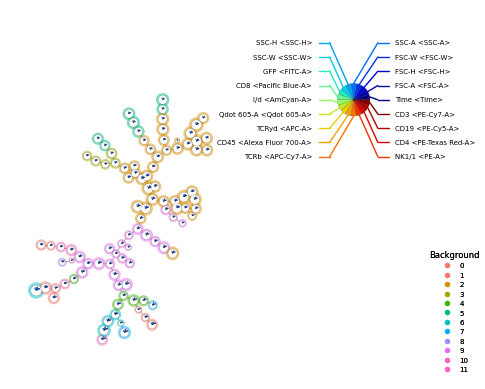

In [8]:
p = fs.pl.plot_stars(fsom, background_values=fsom.get_cluster_data().obs.metaclustering)

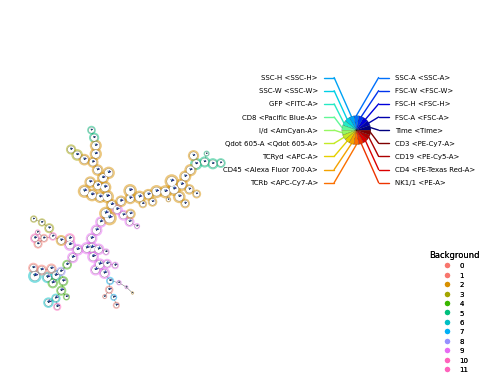

In [9]:
p = fs.pl.plot_stars(fsom_batch, background_values=fsom.get_cluster_data().obs.metaclustering)